In [ ]:
#TensorFlow یک کتابخانه متن باز برای یادگیری ماشین و یادگیری عمیق است که توسط گوگل توسعه داده شده است. این کتابخانه به شما این امکان را می‌دهد که مدل‌های یادگیری عمیق را بسازید و آموزش دهید.
#!pip install tensorflow==2.15.0
#!pip install tensorflow-quantum==0.7.3
!pip install tensorflow==2.15.0 protobuf==3.20.3

import importlib, pkg_resources
importlib.reload(pkg_resources)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

<ipython-input-1-8ea0bbf053b1>:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import importlib, pkg_resources


<module 'pkg_resources' from '/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py'>

In [ ]:
# وارد کردن کتابخانه‌های لازم
import tensorflow as tf  # کتابخانه TensorFlow برای یادگیری عمیق
import tensorflow_quantum as tfq  # کتابخانه TensorFlow Quantum برای یادگیری ماشین کوانتومی
from tensorflow.keras.datasets import fashion_mnist  # مجموعه داده Fashion MNIST برای آزمایش مدل
from tensorflow.keras import regularizers  # ابزارهای منظم‌سازی در Keras
import cirq  # کتابخانه برای کار با مدارهای کوانتومی
import sympy  # کتابخانه برای محاسبات نمادین
import numpy as np  # کتابخانه برای کار با آرایه‌ها و محاسبات عددی
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # معیارهای ارزیابی مدل

# تنظیمات Jupyter Notebook برای نمایش نمودارها به صورت آنلاین
%matplotlib inline
import matplotlib.pyplot as plt  # کتابخانه برای رسم نمودارها
from cirq.contrib.svg import SVGCircuit  # برای نمایش مدارهای کوانتومی به صورت SVG

In [ ]:
# بارگذاری مجموعه داده Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# نرمال‌سازی تصاویر
train_images = train_images / 255.0  # تقسیم بر 255 به منظور نرمال‌سازی مقادیر پیکسل‌ها به بازه [0, 1]
test_images = test_images / 255.0  # انجام همان نرمال‌سازی برای داده‌های آزمایشی

# افزودن بعد کانال برای سازگاری با خط لوله QCNN (تصاویر خاکستری: یک کانال)
train_images = train_images[..., np.newaxis]  # افزودن بعد جدید به انتهای آرایه تصاویر آموزشی
test_images = test_images[..., np.newaxis]  # انجام همان کار برای تصاویر آزمایشی

# چاپ شکل داده‌های آموزشی و آزمایشی قبل از ایجاد زیرمجموعه
print("Training Data Shape (Before Subset):", train_images.shape)
print("Testing Data Shape (Before Subset):", test_images.shape)

4422102/4422102 [==============================] - 0s 0us/step
Training Data Shape (Before Subset): (60000, 28, 28, 1)
Testing Data Shape (Before Subset): (10000, 28, 28, 1)


In [ ]:
# تعداد نمونه‌هایی که در زیرمجموعه‌ها خواهند بود،
# حفظ نسبت اصلی 6:1 از داده‌های آموزشی به آزمایشی
num_train = 6000  # تعداد کل نمونه‌های آموزشی
num_test = 1000   # تعداد کل نمونه‌های آزمایشی

# تعداد نمونه‌ها در هر کلاس (10 کلاس)
num_train_per_class = num_train // 10  # تعداد نمونه‌ها در هر کلاس آموزشی
num_test_per_class = num_test // 10    # تعداد نمونه‌ها در هر کلاس آزمایشی

# لیست برای زیرمجموعه‌ها
train_images_subset = []
train_labels_subset = []
test_images_subset = []
test_labels_subset = []

# تکرار بر روی هر کلاس و نمونه‌گیری برابر
for i in range(10):
    class_indices_train = np.where(train_labels == i)[0]  # پیدا کردن ایندکس‌های کلاس i در داده‌های آموزشی
    class_indices_test = np.where(test_labels == i)[0]    # پیدا کردن ایندکس‌های کلاس i در داده‌های آزمایشی

    # نمونه‌گیری تصادفی از تصاویر در هر کلاس
    sampled_train_indices = np.random.choice(class_indices_train, num_train_per_class, replace=False)  # نمونه‌گیری بدون جایگزینی
    sampled_test_indices = np.random.choice(class_indices_test, num_test_per_class, replace=False)      # نمونه‌گیری بدون جایگزینی

    # افزودن به لیست
    train_images_subset.append(train_images[sampled_train_indices])  # افزودن تصاویر آموزشی نمونه‌گیری شده
    train_labels_subset.append(train_labels[sampled_train_indices])   # افزودن برچسب‌های آموزشی نمونه‌گیری شده
    test_images_subset.append(test_images[sampled_test_indices])      # افزودن تصاویر آزمایشی نمونه‌گیری شده
    test_labels_subset.append(test_labels[sampled_test_indices])      # افزودن برچسب‌های آزمایشی نمونه‌گیری شده

# تبدیل لیست‌ها به آرایه‌ها
train_images_subset = np.concatenate(train_images_subset)  # ترکیب لیست تصاویر آموزشی به یک آرایه
train_labels_subset = np.concatenate(train_labels_subset)   # ترکیب لیست برچسب‌های آموزشی به یک آرایه
test_images_subset = np.concatenate(test_images_subset)     # ترکیب لیست تصاویر آزمایشی به یک آرایه
test_labels_subset = np.concatenate(test_labels_subset)     # ترکیب لیست برچسب‌های آزمایشی به یک آرایه

# چاپ شکل داده‌های آموزشی و آزمایشی پس از ایجاد زیرمجموعه
print("Training Data Shape (After Subset):", train_images_subset.shape)
print("Testing Data Shape (After Subset):", test_images_subset.shape)

# چاپ کلاس‌های منحصر به فرد برای تأیید اینکه همه 10 کلاس شامل شده‌اند
print("Unique Train Labels:", np.unique(train_labels_subset))
print("Unique Test Labels:", np.unique(test_labels_subset))

Training Data Shape (After Subset): (6000, 28, 28, 1)
Testing Data Shape (After Subset): (1000, 28, 28, 1)
Unique Train Labels: [0 1 2 3 4 5 6 7 8 9]
Unique Test Labels: [0 1 2 3 4 5 6 7 8 9]


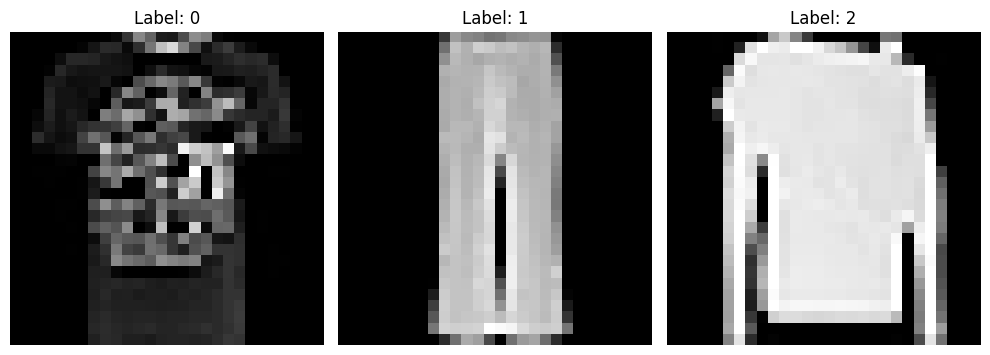

In [ ]:
# تابعی برای نمایش تصاویر نمونه
def display_images(images, labels, num_images=3):
    selected_classes = [0, 1, 2]  # کلاس‌های منتخب برای نمایش تصاویر

    # لیست‌های خالی برای ذخیره تصاویر و برچسب‌ها
    selected_images = []
    selected_labels = []

    # انتخاب یک تصویر از هر کلاس منتخب
    for class_label in selected_classes:
        class_indices = np.where(labels == class_label)[0]  # پیدا کردن ایندکس‌های کلاس
        selected_images.append(images[class_indices[0]])  # انتخاب اولین تصویر از کلاس
        selected_labels.append(labels[class_indices[0]])  # ذخیره برچسب مربوطه

    # تبدیل لیست‌ها به آرایه‌ها
    selected_images = np.array(selected_images)
    selected_labels = np.array(selected_labels)

    # ایجاد یک شکل برای نمایش تصاویر
    fig, axes = plt.subplots(1, num_images, figsize=(10, 4))  # ایجاد زیرنمودارها
    for i, ax in enumerate(axes):
        ax.imshow(selected_images[i].squeeze(), cmap='gray')  # نمایش تصویر با حذف بعد کانال
        ax.set_title(f'Label: {selected_labels[i]}')  # عنوان بر اساس برچسب
        ax.axis('off')  # خاموش کردن محور
    plt.tight_layout()  # تنظیمات نهایی
    plt.show()  # نمایش تصاویر

# نمایش داده‌های نمونه از مجموعه داده پاک
display_images(train_images_subset, train_labels_subset, num_images=3)

Resized Training Data Shape: (6000, 4, 4, 1)
Resized Testing Data Shape: (1000, 4, 4, 1)


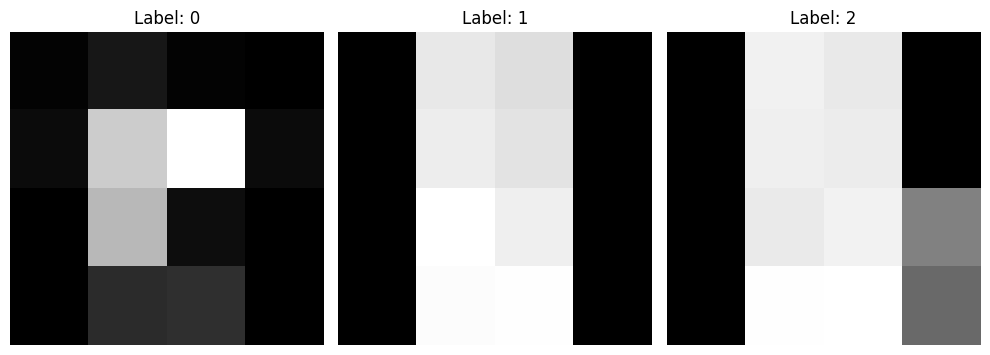

In [ ]:
# تابعی برای تغییر اندازه تصاویر
def resize_images(images, target_size=(4, 4)):
    return tf.image.resize(images, target_size).numpy()  # تغییر اندازه تصاویر به اندازه هدف و تبدیل به آرایه NumPy

# تغییر اندازه داده‌های آموزشی و آزمایشی
train_data_clean = resize_images(train_images_subset)  # تغییر اندازه تصاویر آموزشی
test_data_clean = resize_images(test_images_subset)    # تغییر اندازه تصاویر آزمایشی

# چاپ شکل داده‌های آموزشی و آزمایشی پس از تغییر اندازه
print("Resized Training Data Shape:", train_data_clean.shape)
print("Resized Testing Data Shape:", test_data_clean.shape)

# نمایش داده‌های نمونه از داده‌های آموزشی تغییر اندازه شده
display_images(train_data_clean, train_labels_subset, num_images=3)

Noisy Training Data Shape: (6000, 4, 4, 1)
Noisy Testing Data Shape: (1000, 4, 4, 1)


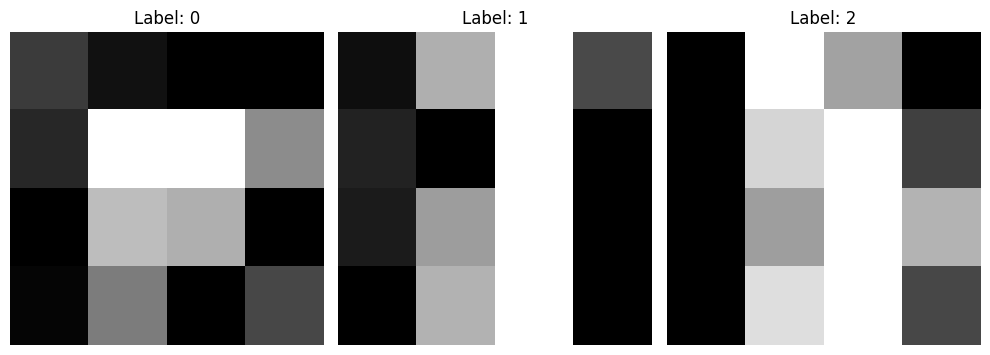

In [ ]:
# تابعی برای افزودن نویز گوسی به تصاویر
def add_gaussian_noise(images, mean=0.0, severity=1):
    severity_levels = [0.08, 0.12, 0.18, 0.26, 0.38]  # سطوح شدت نویز
    stddev = severity_levels[severity - 1]  # دریافت انحراف استاندارد بر اساس شدت (1 تا 5)
    noise = np.random.normal(mean, stddev, images.shape)  # تولید نویز گوسی
    noisy_images = images + noise  # افزودن نویز به تصاویر
    noisy_images = np.clip(noisy_images, 0.0, 1.0)  # اطمینان از اینکه مقادیر پیکسل‌ها در بازه [0.0, 1.0] هستند
    return noisy_images

# افزودن نویز به داده‌های آموزشی و آزمایشی
train_data_noisy = add_gaussian_noise(train_data_clean, severity=5)  # افزودن نویز به داده‌های آموزشی
test_data_noisy = add_gaussian_noise(test_data_clean, severity=5)    # افزودن نویز به داده‌های آزمایشی

# چاپ شکل داده‌های آموزشی و آزمایشی با نویز
print("Noisy Training Data Shape:", train_data_noisy.shape)
print("Noisy Testing Data Shape:", test_data_noisy.shape)

# نمایش داده‌های نمونه از داده‌های آموزشی با نویز
display_images(train_data_noisy, train_labels_subset, num_images=3)

In [ ]:
# تعریف آستانه برای فعال‌سازی حالت کوبیت‌ها
THRESHOLD = 0.5

# ایجاد کدگذاری باینری برای داده‌های آموزشی و آزمایشی
x_train_bin = np.array(train_data_clean > THRESHOLD, dtype=np.float32)  # کدگذاری باینری برای داده‌های آموزشی پاک
x_test_bin = np.array(test_data_clean > THRESHOLD, dtype=np.float32)    # کدگذاری باینری برای داده‌های آزمایشی پاک

x_train_noisy_bin = np.array(train_data_noisy > THRESHOLD, dtype=np.float32)  # کدگذاری باینری برای داده‌های آموزشی با نویز
x_test_noisy_bin = np.array(test_data_noisy > THRESHOLD, dtype=np.float32)    # کدگذاری باینری برای داده‌های آزمایشی با نویز

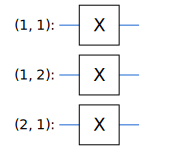

In [ ]:
# تابعی برای تبدیل تصاویر کلاسیک به داده‌های کوانتومی
def convert_to_circuit(image):
    values = np.ndarray.flatten(image)  # تبدیل تصویر به یک آرایه یک بعدی
    qubits = cirq.GridQubit.rect(4, 4)  # ایجاد یک شبکه از کوبیت‌ها به ابعاد 4 در 4
    circuit = cirq.Circuit()  # ایجاد یک مدار کوانتومی خالی
    for i, value in enumerate(values):
        if value:  # اگر مقدار پیکسل برابر با 1 (فعال) باشد
            circuit.append(cirq.X(qubits[i]))  # اضافه کردن گیت X به کوبیت مربوطه
    return circuit  # بازگشت به مدار کوانتومی

# تبدیل تصاویر باینری تمیز به مدارهای کوانتومی
train_clean_circ = [convert_to_circuit(x) for x in x_train_bin]  # برای داده‌های آموزشی تمیز
test_clean_circ = [convert_to_circuit(x) for x in x_test_bin]      # برای داده‌های آزمایشی تمیز

# تبدیل تصاویر باینری با نویز به مدارهای کوانتومی
train_noisy_circ = [convert_to_circuit(x) for x in x_train_noisy_bin]  # برای داده‌های آموزشی با نویز
test_noisy_circ = [convert_to_circuit(x) for x in x_test_noisy_bin]    # برای داده‌های آزمایشی با نویز

# نمایش کوبیت‌هایی که روی آن‌ها گیت قرار گرفته است
SVGCircuit(train_clean_circ[0])  # نمایش مدار کوانتومی اولین تصویر تمیز

In [ ]:
# تبدیل مدارهای cirq به تنسورهای TensorFlow Quantum
train_clean_tfcirc = tfq.convert_to_tensor(train_clean_circ)  # تبدیل مدارهای آموزشی تمیز به تنسور
test_clean_tfcirc = tfq.convert_to_tensor(test_clean_circ)    # تبدیل مدارهای آزمایشی تمیز به تنسور

train_noisy_tfcirc = tfq.convert_to_tensor(train_noisy_circ)  # تبدیل مدارهای آموزشی با نویز به تنسور
test_noisy_tfcirc = tfq.convert_to_tensor(test_noisy_circ)    # تبدیل مدارهای آزمایشی با نویز به تنسور

In [ ]:
# کلاس برای ایجاد لایه‌های مدار کوانتومی
class CircuitLayerBuilder:
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits  # کوبیت‌های داده
        self.readout = readout            # روش خوانش

    def add_layer(self, circuit, prefix):
        # اعمال درهم‌تنیدگی XX و ZZ مشابه مدل QCNN باینری
        for i in range(len(self.data_qubits) - 1):
            circuit.append(cirq.XX(self.data_qubits[i], self.data_qubits[i + 1]))  # درهم‌تنیدگی XX
            circuit.append(cirq.ZZ(self.data_qubits[i], self.data_qubits[i + 1]))  # درهم‌تنیدگی ZZ

        # اعمال گیت‌های کوانتومی پارامتری به هر کوبیت
        for i, qubit in enumerate(self.data_qubits):
            # تعریف پارامترها و افزودن تنظیم‌کننده
            #lambda_ = sympy.Symbol(f'{prefix}_lambda_{i}', regularizer=regularizers.l2(0.01))  # برای استفاده‌های آینده
            theta = sympy.Symbol(f'{prefix}_theta_{i}', regularizer=regularizers.l2(0.01))  # پارامتر theta
            phi = sympy.Symbol(f'{prefix}_phi_{i}', regularizer=regularizers.l2(0.01))      # پارامتر phi

            # افزودن گیت‌های چرخشی پارامتری
            #circuit.append(cirq.rx(lambda_).on(qubit))  # گیت RX (غیرفعال)
            circuit.append(cirq.ry(theta).on(qubit))  # گیت RY با پارامتر theta
            circuit.append(cirq.rz(phi).on(qubit))    # گیت RZ با پارامتر phi
            circuit.append(cirq.ry(theta).on(qubit))  # دوباره گیت RY با پارامتر theta
            circuit.append(cirq.rz(phi).on(qubit))    # دوباره گیت RZ با پارامتر phi

        # تجمع مبتنی بر اندازه‌گیری (غیرفعال)
        # استفاده نمی‌شود زیرا دقت را کاهش می‌دهد زیرا اندازه داده‌ها کوچک است
        #for i in range(0, len(self.data_qubits), 4):
            #circuit.append(cirq.CNOT(self.data_qubits[i], self.data_qubits[i + 1]))
            #circuit.append(cirq.measure(self.data_qubits[i + 1]))

        # به‌روزرسانی کوبیت‌ها برای نشان دادن تجمع (غیرفعال)
        #self.data_qubits = [self.data_qubits[i] for i in range(0, len(self.data_qubits), 2)]

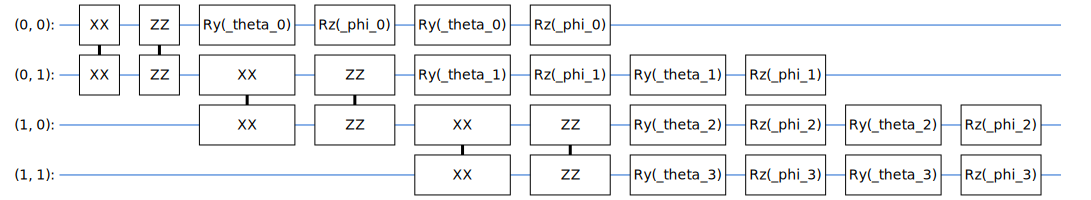

In [ ]:
# تعریف کوبیت‌ها و کوبیت خوانش
data_qubits = cirq.GridQubit.rect(2, 2)  # ایجاد یک شبکه 2x2 از کوبیت‌ها
readout = cirq.GridQubit(-1, -1)         # تعریف کوبیت خوانش

# ایجاد یک مدار نمونه
demo_builder = CircuitLayerBuilder(data_qubits=data_qubits, readout=readout)  # ایجاد یک شی از کلاس CircuitLayerBuilder
circuit = cirq.Circuit()  # ایجاد یک مدار کوانتومی خالی

# افزودن لایه‌ها به مدار
demo_builder.add_layer(circuit, prefix="")  # افزودن لایه به مدار

# نمایش مدار
SVGCircuit(circuit)  # نمایش مدار کوانتومی به صورت گرافیکی

In [ ]:
# تابعی برای ایجاد مدل کوانتومی QCNN و عملیات خوانش
def create_quantum_model():
    data_qubits = cirq.GridQubit.rect(4, 4)  # ایجاد یک شبکه 4x4 برای کوبیت‌های داده
    readout = cirq.GridQubit(-1, -1)         # تعریف کوبیت خوانش در موقعیت [-1,-1]
    circuit = cirq.Circuit()                  # ایجاد یک مدار کوانتومی خالی

    # افزودن لایه‌های گیت به مدار کوانتومی
    builder = CircuitLayerBuilder(data_qubits=data_qubits, readout=readout)  # ایجاد شی از کلاس CircuitLayerBuilder
    builder.add_layer(circuit, prefix="layer1")  # افزودن لایه اول
    builder.add_layer(circuit, prefix="layer2")  # افزودن لایه دوم

    # آماده‌سازی کوبیت خوانش
    circuit.append(cirq.H(readout))  # اعمال گیت هادامارد به کوبیت خوانش
    circuit.append(cirq.measure(readout))  # اندازه‌گیری کوبیت خوانش

    # اندازه‌گیری تمام کوبیت‌ها برای طبقه‌بندی چندکلاسی
    measurements = [cirq.Z(qubit) for qubit in data_qubits]  # اندازه‌گیری کوبیت‌های داده

    return circuit, measurements  # بازگشت مدار و نتایج اندازه‌گیری

In [ ]:
# ایجاد مدار کوانتومی و عملیات خوانش
model_circuit, model_readout = create_quantum_model()

# ساخت مدل تمیز
clean_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string),  # ورودی مدل به صورت رشته
    tfq.layers.PQC(model_circuit, model_readout),  # لایه PQC با مدار کوانتومی و خوانش
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # لایه Dense با 8 نورون و تابع فعال‌سازی ReLU
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))  # لایه Dense برای طبقه‌بندی چندکلاسی (10 کلاس)
])

# کامپایل کردن مدل
clean_model.compile(optimizer='adam',  # استفاده از بهینه‌ساز Adam
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # تابع هزینه برای طبقه‌بندی چندکلاسی
                  metrics=['accuracy'])  # معیار دقت

# چاپ خلاصه مدل
print(clean_model.summary())  # نمایش ساختار مدل

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 16)                64        
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 10)                90        
                                                                 
Total params: 290 (1.13 KB)
Trainable params: 290 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


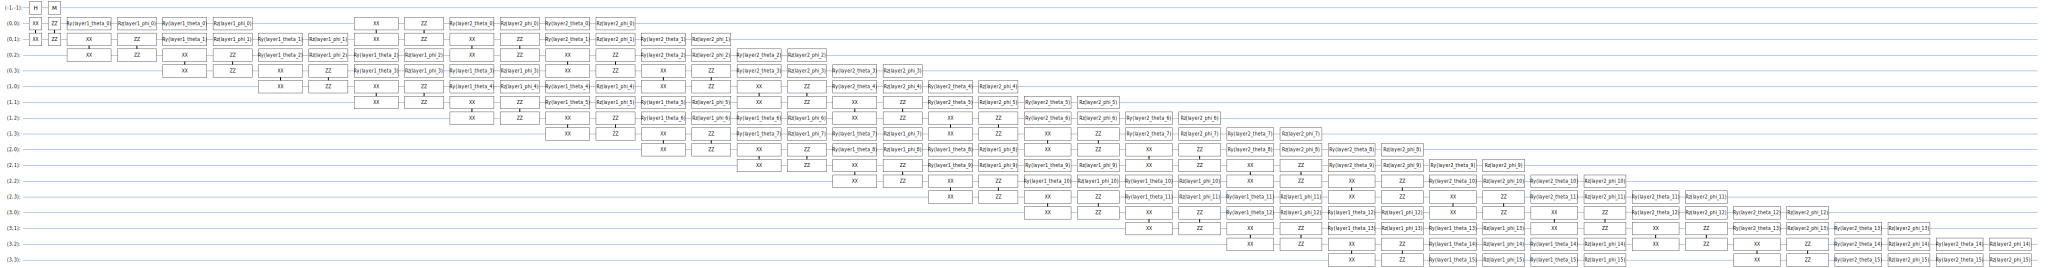

In [ ]:
#در اینجا نمایش بصری مدل مدار کوانتومی آمده است:
SVGCircuit(model_circuit)

In [ ]:
# آموزش مدل تمیز بر روی مجموعه داده‌های تمیز
history_clean = clean_model.fit(
      train_clean_tfcirc, train_labels_subset,  # داده‌های آموزشی و برچسب‌ها
      batch_size=32,  # اندازه بچ 32
      epochs=10,  # تعداد دوره‌های آموزشی
      verbose=1,  # نمایش جزئیات آموزش
      validation_data=(test_clean_tfcirc, test_labels_subset)  # داده‌های اعتبارسنجی
)

# ارزیابی مدل بر روی داده‌های آزمایشی
test_loss_clean, test_acc_clean = clean_model.evaluate(test_clean_tfcirc, test_labels_subset, verbose=2)

# چاپ دقت و از دست دادن آزمون
print(f"Clean Data - Test Accuracy: {test_acc_clean:.4f}, Test Loss: {test_loss_clean:.4f}")
print(f"Clean Data - Training Accuracy: {history_clean.history['accuracy'][-1]:.4f}")

Epoch 1/10
188/188 [==============================] - 1211s 6s/step - loss: 2.3583 - accuracy: 0.1640 - val_loss: 2.2462 - val_accuracy: 0.2170
Epoch 2/10
188/188 [==============================] - 1047s 6s/step - loss: 2.1228 - accuracy: 0.2852 - val_loss: 2.0296 - val_accuracy: 0.3220
Epoch 3/10
188/188 [==============================] - 805s 4s/step - loss: 1.9498 - accuracy: 0.3398 - val_loss: 1.9149 - val_accuracy: 0.3530
Epoch 4/10
188/188 [==============================] - 795s 4s/step - loss: 1.8575 - accuracy: 0.3702 - val_loss: 1.8451 - val_accuracy: 0.3680
Epoch 5/10
188/188 [==============================] - 797s 4s/step - loss: 1.7969 - accuracy: 0.3903 - val_loss: 1.8049 - val_accuracy: 0.3850
Epoch 6/10
188/188 [==============================] - 798s 4s/step - loss: 1.7634 - accuracy: 0.4007 - val_loss: 1.7813 - val_accuracy: 0.3850
Epoch 7/10
188/188 [==============================] - 805s 4s/step - loss: 1.7433 - accuracy: 0.4068 - val_loss: 1.7645 - val_accuracy: 0.40

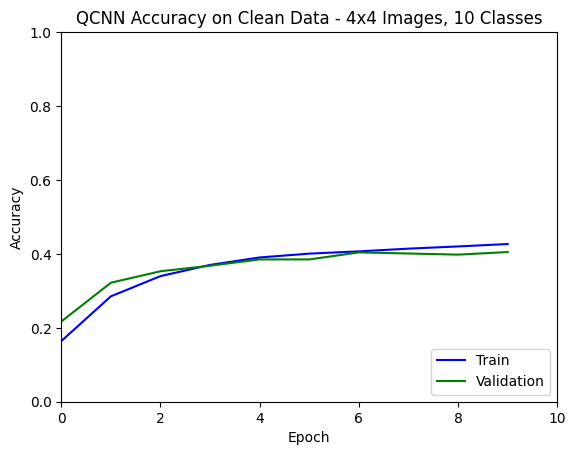

In [ ]:
# تابعی برای نمایش منحنی‌های آموزش و اعتبارسنجی
def plot_metrics(history, metric_name, title, ylim=1, xlim=10):
    plt.title(title)  # عنوان نمودار
    plt.ylim(0, ylim)  # تنظیم محدودیت محور عمودی
    plt.xlim(0, xlim)  # تنظیم محدودیت محور افقی
    plt.plot(history.history[metric_name], color='blue', label='Train')  # نمودار دقت آموزش
    plt.plot(history.history['val_' + metric_name], color='green', label='Validation')  # نمودار دقت اعتبارسنجی
    plt.legend(loc='lower right')  # مکان قرارگیری افسانه
    plt.xlabel("Epoch")  # برچسب محور افقی
    plt.ylabel("Accuracy")  # برچسب محور عمودی

# رسم منحنی‌های دقت برای مدل تمیز
plot_metrics(history_clean, "accuracy", "QCNN Accuracy on Clean Data - 4x4 Images, 10 Classes")

In [ ]:
# ساخت و کامپایل یک مدل دیگر برای داده‌های نویزی
noisy_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string),  # ورودی مدل به صورت رشته
    tfq.layers.PQC(model_circuit, model_readout),  # لایه PQC با مدار کوانتومی و خوانش
    tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # لایه Dense با 8 نورون و تابع فعال‌سازی ReLU
    tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))  # لایه Dense برای طبقه‌بندی چندکلاسی (10 کلاس)
])

# کامپایل کردن مدل
noisy_model.compile(optimizer='adam',  # استفاده از بهینه‌ساز Adam
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),  # تابع هزینه برای طبقه‌بندی چندکلاسی
                  metrics=['accuracy'])  # معیار دقت

# چاپ خلاصه مدل
print(noisy_model.summary())  # نمایش ساختار مدل

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc_1 (PQC)                 (None, 16)                64        
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 10)                90        
                                                                 
Total params: 290 (1.13 KB)
Trainable params: 290 (1.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


/usr/local/lib/python3.11/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# آموزش مدل نویزی بر روی مجموعه داده‌های نویزی
history_noisy = noisy_model.fit(
      train_noisy_tfcirc, train_labels_subset,  # داده‌های آموزشی و برچسب‌ها
      batch_size=32,  # اندازه بچ 32
      epochs=10,  # تعداد دوره‌های آموزشی
      verbose=1,  # نمایش جزئیات آموزش
      validation_data=(test_noisy_tfcirc, test_labels_subset)  # داده‌های اعتبارسنجی
)

# ارزیابی مدل بر روی داده‌های آزمایشی
test_loss_noisy, test_acc_noisy = noisy_model.evaluate(test_noisy_tfcirc, test_labels_subset, verbose=2)

# چاپ دقت و از دست دادن آزمون
print(f"Noisy Data - Test Accuracy: {test_acc_noisy:.4f}, Test Loss: {test_loss_noisy:.4f}")
print(f"Noisy Data - Training Accuracy: {history_noisy.history['accuracy'][-1]:.4f}")

Epoch 1/10
188/188 [==============================] - 821s 4s/step - loss: 2.4557 - accuracy: 0.1178 - val_loss: 2.4000 - val_accuracy: 0.1650
Epoch 2/10
188/188 [==============================] - 832s 4s/step - loss: 2.3462 - accuracy: 0.1760 - val_loss: 2.2872 - val_accuracy: 0.2100
Epoch 3/10
188/188 [==============================] - 829s 4s/step - loss: 2.1991 - accuracy: 0.2157 - val_loss: 2.1279 - val_accuracy: 0.2320
Epoch 4/10
188/188 [==============================] - 841s 4s/step - loss: 2.0686 - accuracy: 0.2515 - val_loss: 2.0405 - val_accuracy: 0.2550
Epoch 5/10
188/188 [==============================] - 866s 5s/step - loss: 2.0122 - accuracy: 0.2667 - val_loss: 2.0012 - val_accuracy: 0.2720
Epoch 6/10
188/188 [==============================] - 864s 5s/step - loss: 1.9861 - accuracy: 0.2762 - val_loss: 1.9799 - val_accuracy: 0.2780
Epoch 7/10
188/188 [==============================] - 879s 5s/step - loss: 1.9704 - accuracy: 0.2812 - val_loss: 1.9647 - val_accuracy: 0.2910

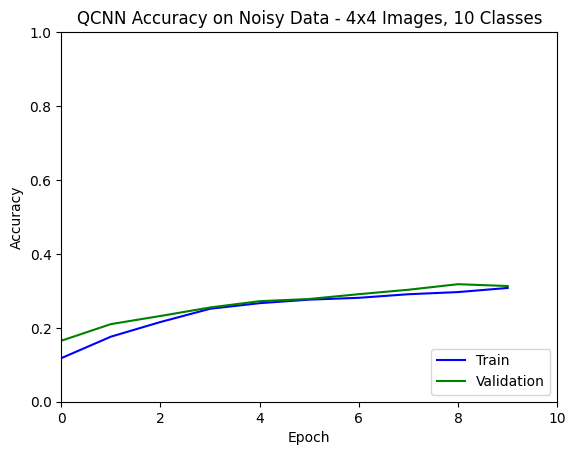

In [ ]:
# رسم معیارهای مربوط به مدل نویزی
plot_metrics(history_noisy, "accuracy", "QCNN Accuracy on Noisy Data - 4x4 Images, 10 Classes")

In [ ]:
# حالا برای مقایسه دیگر معیارها بین هر دو مدل
# استخراج برچسب‌های واقعی
y_true = test_labels_subset

# پیش‌بینی‌های مدل تمیز
y_pred_clean = clean_model.predict(test_clean_tfcirc)  # پیش‌بینی بر اساس داده‌های تمیز
y_pred_clean = np.argmax(y_pred_clean, axis=-1)  # تبدیل احتمالات به ایندکس‌های کلاس

# پیش‌بینی‌های مدل نویزی
y_pred_noisy = noisy_model.predict(test_noisy_tfcirc)  # پیش‌بینی بر اساس داده‌های نویزی
y_pred_noisy = np.argmax(y_pred_noisy, axis=-1)  # تبدیل احتمالات به ایندکس‌های کلاس

32/32 [==============================] - 20s 623ms/step


In [ ]:
# محاسبه معیارهای مدل تمیز
accuracy_clean = accuracy_score(y_true, y_pred_clean)  # دقت
precision_clean = precision_score(y_true, y_pred_clean, average='weighted')  # دقت (Precision)
recall_clean = recall_score(y_true, y_pred_clean, average='weighted')  # یادآوری (Recall)
f1_clean = f1_score(y_true, y_pred_clean, average='weighted')  # نمره F1

# چاپ معیارهای داده‌های تمیز
print("\nClean Data Metrics:")
print(f"Accuracy: {accuracy_clean:.4f}")
print(f"Precision: {precision_clean:.4f}")
print(f"Recall: {recall_clean:.4f}")
print(f"F1 Score: {f1_clean:.4f}")


Clean Data Metrics:
Accuracy: 0.4050
Precision: 0.4072
Recall: 0.4050
F1 Score: 0.3609


In [ ]:
# محاسبه معیارهای مدل نویزی
accuracy_noisy = accuracy_score(y_true, y_pred_noisy)  # دقت
precision_noisy = precision_score(y_true, y_pred_noisy, average='weighted')  # دقت (Precision)
recall_noisy = recall_score(y_true, y_pred_noisy, average='weighted')  # یادآوری (Recall)
f1_noisy = f1_score(y_true, y_pred_noisy, average='weighted')  # نمره F1

# چاپ معیارهای داده‌های نویزی
print("\nNoisy Data Metrics:")
print(f"Accuracy: {accuracy_noisy:.4f}")
print(f"Precision: {precision_noisy:.4f}")
print(f"Recall: {recall_noisy:.4f}")
print(f"F1 Score: {f1_noisy:.4f}")


Noisy Data Metrics:
Accuracy: 0.3130
Precision: 0.2870
Recall: 0.3130
F1 Score: 0.2722


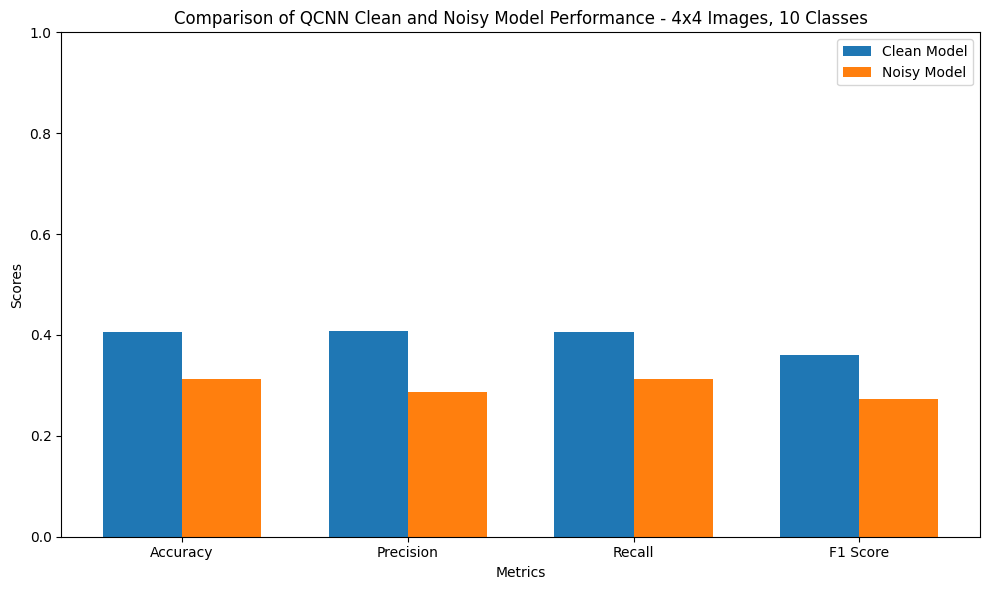

In [ ]:
# تعریف معیارها و مقادیر مربوطه
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']  # معیارها
clean_values = [accuracy_clean, precision_clean, recall_clean, f1_clean]  # مقادیر مدل تمیز
noisy_values = [accuracy_noisy, precision_noisy, recall_noisy, f1_noisy]  # مقادیر مدل نویزی

# تنظیمات برای نمودار میله‌ای
x = np.arange(len(metrics))  # مکان برچسب‌ها
width = 0.35  # عرض میله‌ها

# ایجاد نمودار
fig, ax = plt.subplots(figsize=(10, 6))  # تنظیم اندازه نمودار
rects1 = ax.bar(x - width/2, clean_values, width, label='Clean Model')  # میله‌های مدل تمیز
rects2 = ax.bar(x + width/2, noisy_values, width, label='Noisy Model')  # میله‌های مدل نویزی

# تنظیمات نمودار
ax.set_xlabel('Metrics')  # برچسب محور X
ax.set_ylabel('Scores')  # برچسب محور Y
ax.set_title('Comparison of QCNN Clean and Noisy Model Performance - 4x4 Images, 10 Classes')  # عنوان نمودار
ax.set_xticks(x)  # محل برچسب‌های محور X
ax.set_xticklabels(metrics)  # برچسب‌های محور X
ax.legend()  # نمایش افسانه
ax.set_ylim(0, 1)  # تنظیم محدوده محور Y

# نمایش نمودار
plt.tight_layout()  # تنظیم ابعاد برای جلوگیری از برش
plt.show()  # نمایش نمودار